# KuaiRec Data Preparation

This notebook processes the KuaiRec dataset (https://kuairec.com/) to build a training DataFrame for a recommender system value model. The goal is to construct clean labels and features that let us estimate how valuable a candidate video is for a given user and context.

We focus on four engagement “heads,” each defined at the interaction level:

- `y_complete`: whether the user watched the full video.
- `y_long`: whether the user had a long watch (e.g., watch ratio ≥ 1.5 or play duration > 12 seconds).
- `y_rewatch`: whether the user effectively rewatched the content (e.g., watch ratio ≥ 2).
- `y_neg`: whether the interaction is negative (e.g., very short watch such as play duration < 2 seconds).

A value model uses these four heads as targets and learns to predict the probability of each head for every user–video pair. At serving time, the system can combine the predicted head probabilities into a single value score using a weighted sum and then rank candidate videos by this value score:
$$
\text{score} \;=\; w_1 \,\hat y_{\text{complete}}
               \;+\; w_2 \,\hat y_{\text{long}}
               \;+\; w_3 \,\hat y_{\text{rewatch}}
               \;-\; w_4 \,\hat y_{\text{neg}},
$$
where $\hat y_{(\cdot)}$ are the predicted head probabilities and $w_1,\dots,w_4$ are weights that encode how much the platform values each type of engagement and will be estimated later. Candidate videos are then ranked by this value score.




### 1. Data cleaning and some descriptive statistics for `big_matrix.csv`

#### (1) Data cleaning: detect burst, define sessions and create head labels

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
# Load big.matrix.csv
BASE = Path("/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data")
OUT = BASE / "processed"

OUT.mkdir(parents=True, exist_ok=True)

big_matrix_path = BASE / "big_matrix.csv"
df = pd.read_csv(big_matrix_path, low_memory=False)

In [3]:
# convert "time" column from string to datatime type
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df["timestamp"].dtype
pd.to_datetime(df["timestamp"].iloc[0], unit="s")

print(df["time"].dtype)
df["time"].head(10)

datetime64[ns]


0   2020-07-05 00:08:23.438
1   2020-07-05 00:13:41.297
2   2020-07-05 00:16:06.687
3   2020-07-05 00:20:26.792
4   2020-07-05 00:43:05.128
5   2020-07-05 01:00:25.500
6   2020-07-05 03:28:02.320
7   2020-07-05 22:22:11.813
8   2020-07-06 00:14:06.245
9   2020-07-06 00:14:48.800
Name: time, dtype: datetime64[ns]

time
2020-06-23          1
2020-06-24          1
2020-06-25        138
2020-06-26         59
2020-06-27         33
2020-06-28         91
2020-06-29         12
2020-06-30         22
2020-07-01         22
2020-07-02         50
2020-07-03         36
2020-07-04        144
2020-07-05     188240
2020-07-06     220784
2020-07-07     258665
2020-07-08     280352
2020-07-09     306445
2020-07-10     319459
2020-07-11     303177
2020-07-12     314523
2020-07-13        100
2020-07-24          1
2020-07-25          8
2020-07-26          1
2020-07-27          3
2020-07-30        124
2020-07-31        609
2020-08-01     642074
2020-08-02     642328
2020-08-03     672447
2020-08-04     647462
2020-08-05    1300532
2020-08-06     674723
2020-08-07     607605
2020-08-08     648627
2020-08-09     594151
2020-08-10     577044
2020-08-11        140
2020-08-17        381
2020-08-19          1
2020-08-21          1
2020-08-22          1
2020-08-23         23
2020-08-24         36
2020-08-25         40
2020-

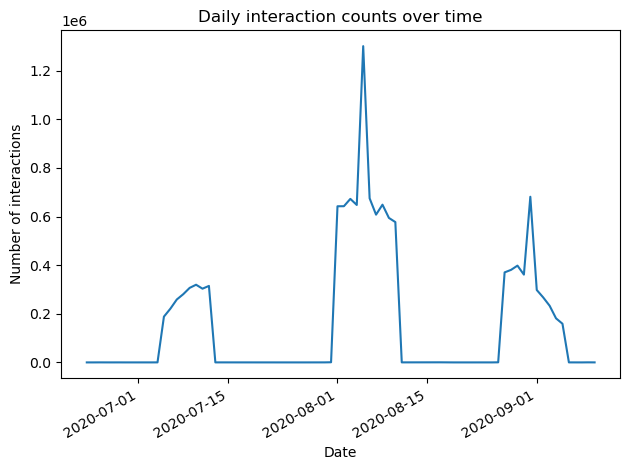

In [4]:
# Define 3 bursts in the dataset

# count interactions per day
daily_counts = (
    df.set_index("time")
      .resample("D")
      .size()
)

daily_counts = daily_counts[daily_counts > 0]
print(daily_counts)

# Plot the number of interactions
daily_counts.plot()
plt.xlabel("Date")
plt.ylabel("Number of interactions")
plt.title("Daily interaction counts over time")
plt.tight_layout()

In [5]:
# Manually chosen burst ranges
burst_ranges = [
    ("2020-07-05", "2020-07-12"),  # burst 1
    ("2020-08-01", "2020-08-10"),  # burst 2
    ("2020-08-27", "2020-09-05"),  # burst 3
]

# Normalize interaction timestamps to date
df_date = df["time"].dt.normalize()

# Initialize burst_id as NA
burst_id = pd.Series(pd.NA, index=df.index, dtype="Int64")

for i, (start, end) in enumerate(burst_ranges, start=1):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    mask = (df_date >= start) & (df_date <= end)
    burst_id[mask] = i

df["burst_id"] = burst_id

# Keep only interactions inside the three bursts
df = df[df["burst_id"].notna()].copy()

print(df["burst_id"].value_counts().sort_index())


burst_id
1    2191645
2    7006993
3    3329274
Name: count, dtype: Int64


In [6]:
# Define sessions using 1-hour gaps between interactions for each user
df.sort_values(["user_id", "time"], inplace=True)
gap = (
    df.groupby("user_id")["time"]
    .diff()
    .dt.total_seconds()
    .fillna(np.inf)
)

df["session"] = (gap > 3600).groupby(df["user_id"]).cumsum().astype("Int64")
df["sess_rank"] = df.groupby(["user_id","session"]).cumcount().astype("int32") + 1
df["sess_len"] = df.groupby(["user_id","session"])["video_id"].transform("size").astype("int32")

df.head(3)

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,burst_id,session,sess_rank,sess_len
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397,1,1,1,6
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082,1,1,2,6
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613,1,1,3,6


In [7]:
# Create 4 head labels

# y_complete = 1: watch_ratio >= 1 (about 34% of the interactions)
# y_long = 1: watch_ratio >= 1.5 or play_duration > 12s (about 15% for each condition, 21.5% for both)
# y_rewatch = 1: watch_ratio >= 2 (about 7.5% of the interactions)
# y_neg = 1: play_duration < 2s (about 12.5% of the iteractions)

df["y_complete"] = (df["watch_ratio"] >= 1).astype("int8")
df["y_long"] = ((df["play_duration"] >= 12000) | (df["watch_ratio"] >= 1.5)).astype("int8")
df["y_rewatch"] = (df["watch_ratio"] >= 2).astype("int8")
df["y_neg"] = (df["play_duration"] <= 2000).astype("int8")

#### (2) Descriptive statistics for number of sessions, session length, video / play duration and watch ratio

Number of sessions per user:
count    7176.000000
mean       77.423495
std        35.374788
min         6.000000
25%        49.000000
50%        74.000000
75%       102.000000
max       285.000000
Name: session, dtype: float64


Text(0.5, 1.0, 'Distribution of number of sessions per user')

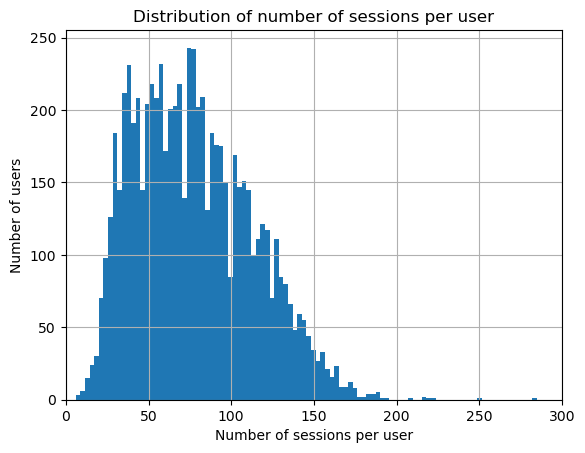

In [8]:
# Some descriptive statistics

# number of sessions per user
num_of_session_per_user = df.groupby("user_id")["session"].nunique()
print("Number of sessions per user:")
print(num_of_session_per_user.describe())
# Histogram: number of sessions per user
num_of_session_per_user.hist(bins=100)
plt.xlim(0, 300)  # adjust this after seeing the range; or drop it at first
plt.xlabel("Number of sessions per user")
plt.ylabel("Number of users")
plt.title("Distribution of number of sessions per user")

Session lengths (pooled across users):
count    555591.000000
mean         22.548803
std          46.804389
min           1.000000
25%           2.000000
50%           7.000000
75%          22.000000
max        3299.000000
Name: sess_len, dtype: float64


Text(0.5, 1.0, 'Distribution of session lengths')

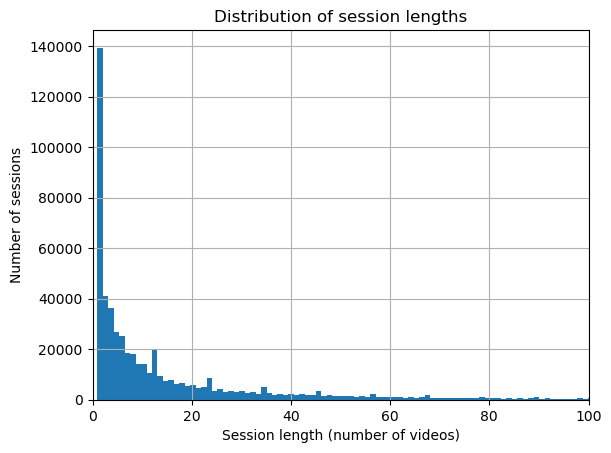

In [9]:
# session length (pooled across users)
# notice that the distribution is highly right-skewed
session_lengths = df.drop_duplicates(["user_id","session"])["sess_len"]

print("Session lengths (pooled across users):")
print(session_lengths.describe())
session_lengths.hist(bins=3000)
plt.xlim(0, 100)
plt.xlabel("Session length (number of videos)")
plt.ylabel("Number of sessions")
plt.title("Distribution of session lengths")

count    10728.000000
mean        12.627945
std         15.652388
min          0.140000
25%          6.467000
50%          9.176000
75%         12.151250
max        315.040000
Name: video_duration, dtype: float64


Text(0.5, 1.0, 'Distribution of video durations')

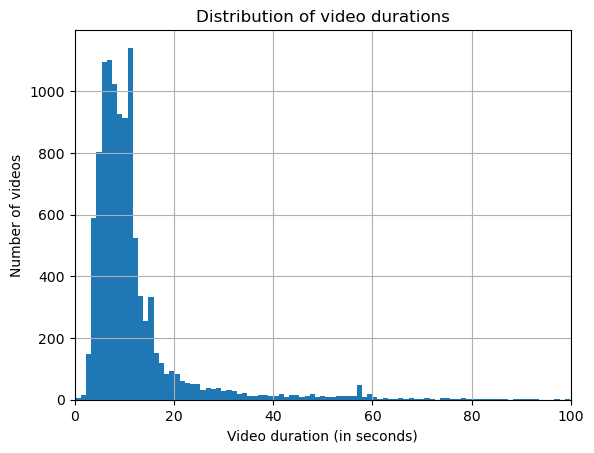

In [10]:
# video duration

video_duration_seconds = df.drop_duplicates(["video_id"])["video_duration"] / 1000
print(video_duration_seconds.describe())
video_duration_seconds.hist(bins=300)
plt.xlim(0,100)
plt.xlabel("Video duration (in seconds)")
plt.ylabel("Number of videos")
plt.title("Distribution of video durations")

count    1.252791e+07
mean     9.027021e+00
std      1.547373e+01
min      0.000000e+00
25%      4.218000e+00
50%      7.276000e+00
75%      1.034900e+01
max      9.996390e+02
Name: play_duration, dtype: float64


Text(0.5, 1.0, 'Distribution of play durations (pooled across users)')

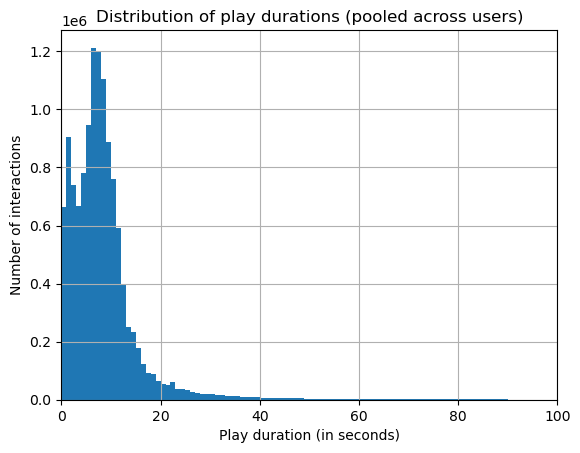

In [11]:
# play duration
play_duration_seconds = df["play_duration"] / 1000
print(play_duration_seconds.describe())
play_duration_seconds.hist(bins=1000)
plt.xlim(0,100)
plt.xlabel("Play duration (in seconds)")
plt.ylabel("Number of interactions")
plt.title("Distribution of play durations (pooled across users)")

In [12]:
df.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,burst_id,session,sess_rank,sess_len,y_complete,y_long,y_rewatch,y_neg
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397,1,1,1,6,1,1,0,0
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082,1,1,2,6,1,1,0,0
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613,1,1,3,6,0,0,0,1
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885,1,1,4,6,0,0,0,1
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000,1,1,5,6,0,0,0,1


count    1.252791e+07
mean     9.444975e-01
std      1.674521e+00
min      0.000000e+00
25%      3.148248e-01
50%      7.234556e-01
75%      1.177636e+00
max      5.734571e+02
Name: watch_ratio, dtype: float64


Text(0.5, 1.0, 'Distribution of watch ratio (pooled across users)')

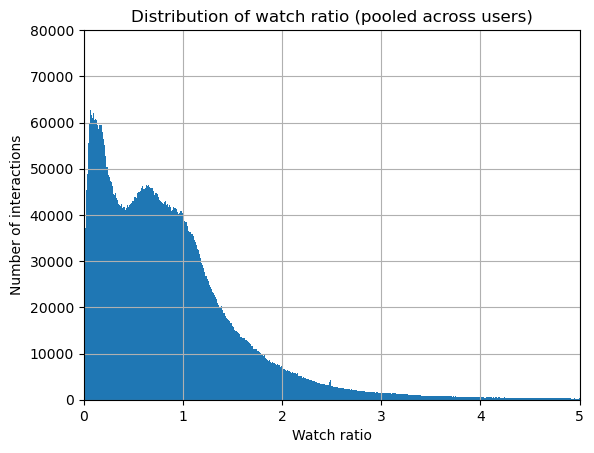

In [13]:
# Watch ratio
watch_ratio = df["watch_ratio"]
print(watch_ratio.describe())
watch_ratio.hist(bins=100000)
plt.xlim(0,5)
plt.ylim(0,80000)
plt.xlabel("Watch ratio")
plt.ylabel("Number of interactions")
plt.title("Distribution of watch ratio (pooled across users)")

In [14]:
# helper block for computing fraction of interactions
# mask = (df["play_duration"] >= 12000) | (df["watch_ratio"] >= 1.5)
# fraction = mask.mean()
# print(fraction)


### 2. Merge user static features from `user_features.csv`


| Feature name                 | Type        | Description |
|-----------------------------|-------------|-------------|
| `u_user_active_degree`      | categorical | Platform-defined user activity segment (e.g., low / medium / high). |
| `u_is_lowactive_period`     | binary      | Whether the user is currently in a low-activity period. |
| `u_is_live_streamer`        | binary      | Whether the user is also a live streamer. |
| `u_is_video_author`         | binary      | Whether the user is a video creator on the platform. |
| `u_follow_user_num`         | numeric     | Number of accounts the user follows. |
| `u_follow_user_num_range`   | categorical | Binned version of `u_follow_user_num`. |
| `u_fans_user_num`           | numeric     | Number of followers (fans) the user has. |
| `u_fans_user_num_range`     | categorical | Binned version of `u_fans_user_num`. |
| `u_friend_user_num`         | numeric     | Number of mutual friends. |
| `u_friend_user_num_range`   | categorical | Binned version of `u_friend_user_num`. |
| `u_register_days`           | numeric     | Days since account registration. |
| `u_register_days_range`     | categorical | Binned version of `u_register_days`. |
| `u_onehot_feat0`–`u_onehot_feat17` | categorical | Platform-provided one-hot user segments / tags. |
| `u_follow_user_num_log1p`   | numeric     | Log-transformed `u_follow_user_num`. |
| `u_fans_user_num_log1p`     | numeric     | Log-transformed `u_fans_user_num`. |
| `u_friend_user_num_log1p`   | numeric     | Log-transformed `u_friend_user_num`. |
| `u_register_days_log1p`     | numeric     | Log-transformed `u_register_days`. |

In [15]:
user_path = BASE / "user_features.csv"
user_header = pd.read_csv(user_path, nrows=0).columns.tolist()

# Categorize 4 groups of user features
LOW_CARD_CATS = ["user_active_degree","follow_user_num_range","fans_user_num_range","friend_user_num_range","register_days_range"] # low-cardinality features

BIN_FLAGS = ["is_lowactive_period","is_live_streamer","is_video_author"] # binary flags features

NUMS = ["follow_user_num","fans_user_num","friend_user_num","register_days"] # numerical features

ONEHOTS = [f"onehot_feat{i}" for i in range(18)] # encrypted one-hot features

usecols = ["user_id"] + [c for c in (LOW_CARD_CATS + BIN_FLAGS + NUMS + ONEHOTS) if c in user_header]
user_feature = pd.read_csv(user_path, usecols=usecols, low_memory=False)

# data cleaning and create log1p transformations
for c in BIN_FLAGS:
    if c in user_feature.columns:
        user_feature[c] = pd.to_numeric(user_feature[c], errors="coerce").fillna(0).astype("int8").clip(0,1)

for c in LOW_CARD_CATS + ONEHOTS:
    if c in user_feature.columns:
        user_feature[c] = user_feature[c].astype("string").fillna("unknown").replace({"": "unknown"}).astype("category")

for c in NUMS:
    if c in user_feature.columns:
        user_feature[c] = pd.to_numeric(user_feature[c], errors="coerce").astype("float32")
        user_feature[f"{c}_log1p"] = np.log1p(user_feature[c].clip(lower=0)).astype("float32")

# Rename each feature columns by adding a "u_" prefix
rename_map = {c: f"u_{c}" for c in user_feature.columns if c != "user_id"}
user_feature.rename(columns=rename_map, inplace=True)

# Merge two datasets by user_id
before = set(df.columns)
df = df.merge(user_feature, on="user_id", how="left")
after = set(df.columns)
added = sorted(after - before)
print("Number of added columns on user features:", len(df.columns) - len(before))
print("Added columns:\n", added)

Number of added columns on user features: 34
Added columns:
 ['u_fans_user_num', 'u_fans_user_num_log1p', 'u_fans_user_num_range', 'u_follow_user_num', 'u_follow_user_num_log1p', 'u_follow_user_num_range', 'u_friend_user_num', 'u_friend_user_num_log1p', 'u_friend_user_num_range', 'u_is_live_streamer', 'u_is_lowactive_period', 'u_is_video_author', 'u_onehot_feat0', 'u_onehot_feat1', 'u_onehot_feat10', 'u_onehot_feat11', 'u_onehot_feat12', 'u_onehot_feat13', 'u_onehot_feat14', 'u_onehot_feat15', 'u_onehot_feat16', 'u_onehot_feat17', 'u_onehot_feat2', 'u_onehot_feat3', 'u_onehot_feat4', 'u_onehot_feat5', 'u_onehot_feat6', 'u_onehot_feat7', 'u_onehot_feat8', 'u_onehot_feat9', 'u_register_days', 'u_register_days_log1p', 'u_register_days_range', 'u_user_active_degree']


### 3. Merge item static features from `item_daily_features.csv` and `kuairec_caption_category.csv`

| Feature name                 | Type        | Description |
|-----------------------------|-------------|-------------|
| `i_author_id`               | categorical | ID of the video’s creator. |
| `i_video_type`              | categorical | High-level video type (e.g., normal / ad / other). |
| `i_upload_type`             | categorical | Upload source / method (e.g., local, repost, etc.). |
| `i_visible_status`          | categorical | Visibility status (e.g., normal, limited, hidden). |
| `i_music_id`                | categorical | Background music / sound ID. |
| `i_video_tag_id`            | categorical | Main tag / topic ID for the video. |
| `i_video_tag_name`          | categorical | Human-readable name for the main tag. |
| `i_video_duration`          | numeric     | The time duration of this video (in milliseconds). |
| `i_aspect_ratio`            | numeric     | Video width / height ratio. |
| `i_age_since_upload_days`   | numeric     | Days since the video was uploaded at interaction time. |
| `i_cat_level1_id`           | categorical | Top-level content category ID. |
| `i_cat_level1_name`         | categorical | Top-level content category name. |
| `i_cat_level2_id`           | categorical | Mid-level content category ID. |
| `i_cat_level2_name`         | categorical | Mid-level content category name. |
| `i_cat_level3_id`           | categorical | Fine-grained content category ID. |
| `i_cat_level3_name`         | categorical | Fine-grained content category name. |

#### (i) Add item static attribute features from `item_daily_features.csv`

In [16]:
item_path = BASE / "item_daily_features.csv"
item_header = pd.read_csv(item_path, nrows=0).columns.tolist()

usecols = [
    "video_id",
    "author_id",
    "video_type",
    "upload_dt",
    "upload_type",
    "visible_status",
    "video_width",
    "video_height",
    "music_id",
    "video_tag_id",
    "video_tag_name",
] # only static features (instead of daily features) are used 

# Daily features are not used because:
# they are highly correlated with the target labels and can cause overfitting.
# they greatly increase model and feature-pipeline complexity for limited gain.
# they make it harder to guarantee proper time alignment and avoid data leakage.

item_feature = pd.read_csv(item_path, usecols= usecols, low_memory=False)

per_video = item_feature.groupby("video_id", as_index=False).first() # keep one row per video

# Create upload timestamp
per_video["i_upload_dt"] = pd.to_datetime(
    per_video["upload_dt"],
    errors="coerce"
)

# Create aspect ratio (width / height)
w = pd.to_numeric(per_video["video_width"], errors="coerce")
h = pd.to_numeric(per_video["video_height"], errors="coerce").replace(0, np.nan)
per_video["i_aspect_ratio"] = (w / h).astype("float32")

# Categorical item meta, prefixed with i_ and dealt with missing values
cat_cols = [
    "author_id",
    "video_type",
    "upload_type",
    "visible_status",
    "music_id",
    "video_tag_id",
    "video_tag_name",
]

for c in cat_cols:
    per_video[f"i_{c}"] = (
        per_video[c]
        .astype("string")
        .fillna("unknown")
        .replace({"": "unknown"})
        .astype("category")
    )

# Only keep relevant columns for merging
keep_cols = ["video_id", "i_aspect_ratio", "i_upload_dt"]
keep_cols += [f"i_{c}" for c in cat_cols]

per_video = per_video[keep_cols]


# Merge by video_id
before = set(df.columns)
df = df.merge(per_video, on="video_id", how="left")

# Create i_age_since_upload feature using time and i_upload_ts after merging

df["i_age_since_upload_days"] = (
    (df["time"] - df["i_upload_dt"])
).dt.days.astype("float32").clip(lower=0)

df.drop(columns=["i_upload_dt"], inplace=True)


# add prefix to video_duration and reorder it
df.rename(columns={"video_duration": "i_video_duration"}, inplace=True)
df["i_video_duration"] = df["i_video_duration"].astype("float32")

cols = df.columns.tolist()
vid_duration = cols.pop(cols.index("i_video_duration"))

insert_pos = cols.index("i_video_tag_name") + 1
cols.insert(insert_pos, vid_duration)
df = df[cols]


after = set(df.columns)
added = after - before

print("Number of added columns on item features:", len(added))
print("Added columns:\n", added)

Number of added columns on item features: 10
Added columns:
 {'i_upload_type', 'i_visible_status', 'i_video_duration', 'i_age_since_upload_days', 'i_music_id', 'i_video_tag_id', 'i_video_type', 'i_video_tag_name', 'i_author_id', 'i_aspect_ratio'}


#### (ii) Add category features from `kuairec_caption_category.csv` and build dictionaries for 3-level category

In [17]:
cat_path = BASE / "kuairec_caption_category.csv"

# Build dictionaries for 3-level categories
usecols = ["video_id",
    "first_level_category_id", "first_level_category_name",
    "second_level_category_id", "second_level_category_name",
    "third_level_category_id",  "third_level_category_name",
]

category_per_video = pd.read_csv(
    cat_path,
    usecols=usecols,
    engine="python",
    encoding="utf-8",
    on_bad_lines="warn",
)

def make_map(df, id_col, name_col):
    tmp = (
        df[[id_col, name_col]]
        .dropna()
        .drop_duplicates(subset=[id_col])
    )
    return dict(zip(tmp[id_col], tmp[name_col]))

cat_map_lvl1 = make_map(category_per_video, "first_level_category_id",  "first_level_category_name")
cat_map_lvl2 = make_map(category_per_video, "second_level_category_id", "second_level_category_name")
cat_map_lvl3 = make_map(category_per_video, "third_level_category_id",  "third_level_category_name")

cat_maps = [cat_map_lvl1, cat_map_lvl2, cat_map_lvl3]
for i in range(3):
    print(f"Number of level {i+1} category:", len(cat_maps[i]))

# Merge category ids (all 3 levels)
category_per_video["video_id"] = pd.to_numeric(
    category_per_video["video_id"], errors="coerce"
)


before = set(df.columns)
df = df.merge(category_per_video, on="video_id", how="left")
added = sorted(set(df.columns) - before)

print("Number of added columns on item categories:", len(added))
print("Added columns:", added)

Number of level 1 category: 41
Number of level 2 category: 139
Number of level 3 category: 220
Number of added columns on item categories: 6
Added columns: ['first_level_category_id', 'first_level_category_name', 'second_level_category_id', 'second_level_category_name', 'third_level_category_id', 'third_level_category_name']


In [18]:
# Adding "i_" prefix to category features
rename_map = {
    "first_level_category_id":  "i_cat_level1_id",
    "first_level_category_name": "i_cat_level1_name",
    "second_level_category_id": "i_cat_level2_id",
    "second_level_category_name": "i_cat_level2_name",
    "third_level_category_id":  "i_cat_level3_id",
    "third_level_category_name": "i_cat_level3_name",
}
df.rename(columns=rename_map, inplace=True)
df.columns

Index(['user_id', 'video_id', 'play_duration', 'time', 'date', 'timestamp',
       'watch_ratio', 'burst_id', 'session', 'sess_rank', 'sess_len',
       'y_complete', 'y_long', 'y_rewatch', 'y_neg', 'u_user_active_degree',
       'u_is_lowactive_period', 'u_is_live_streamer', 'u_is_video_author',
       'u_follow_user_num', 'u_follow_user_num_range', 'u_fans_user_num',
       'u_fans_user_num_range', 'u_friend_user_num', 'u_friend_user_num_range',
       'u_register_days', 'u_register_days_range', 'u_onehot_feat0',
       'u_onehot_feat1', 'u_onehot_feat2', 'u_onehot_feat3', 'u_onehot_feat4',
       'u_onehot_feat5', 'u_onehot_feat6', 'u_onehot_feat7', 'u_onehot_feat8',
       'u_onehot_feat9', 'u_onehot_feat10', 'u_onehot_feat11',
       'u_onehot_feat12', 'u_onehot_feat13', 'u_onehot_feat14',
       'u_onehot_feat15', 'u_onehot_feat16', 'u_onehot_feat17',
       'u_follow_user_num_log1p', 'u_fans_user_num_log1p',
       'u_friend_user_num_log1p', 'u_register_days_log1p', 'i_aspect_ra

In [19]:
# There are some number of rows with missing L1 category
n_nan = df["i_cat_level1_id"].isna().sum()
n_total = len(df)

print(n_nan, n_total)

df["i_cat_level1_id"] = df["i_cat_level1_id"].fillna(-124) # replace it with -124 (UNKNOWN)
df["i_cat_level1_name"] = (
    df["i_cat_level1_name"]
    .replace({None: "UNKNOWN"})
    .fillna("UNKNOWN")
)

8989 12527912


### 4. Add context features (time of a day and weekend dummies)

| Feature name       | Type    | Description |
|--------------------|---------|-------------|
| `ctx_hour_sin`     | numeric | Sinusoidal encoding of time-of-day (captures hour on a circle). |
| `ctx_hour_cos`     | numeric | Cosine encoding of time-of-day (paired with `ctx_hour_sin`). |
| `ctx_is_weekend`   | binary  | 1 if the interaction happens on Saturday/Sunday, 0 otherwise. |

In [20]:
# Add time features for day
df["ts"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce") # seconds since midnight
secs = (df["ts"].dt.hour * 3600 + df["ts"].dt.minute * 60 + df["ts"].dt.second).astype("float32")
frac_day = secs / np.float32(24*3600)
df["ctx_hour_sin"] = np.sin(2*np.pi*frac_day).astype("float32")
df["ctx_hour_cos"] = np.cos(2*np.pi*frac_day).astype("float32")

# Add weekend dummies
df["ctx_dow"] = df["ts"].dt.dayofweek.astype("int8")
df["ctx_is_weekend"] = df["ctx_dow"].isin([5,6]).astype("int8")

# Drop redundant columns
df.drop(columns=["ts", "ctx_dow"], inplace=True)

### 5. Add history-based features

| Feature name                 | Type    | Description |
|-----------------------------|---------|-------------|
| `hist_ema_y_complete`       | numeric | User-level EMA of completion label over past interactions. |
| `hist_ema_y_long`           | numeric | User-level EMA of long-watch label over past interactions. |
| `hist_ema_y_rewatch`        | numeric | User-level EMA of rewatch label over past interactions. |
| `hist_ema_y_neg`            | numeric | User-level EMA of negative-skip label over past interactions. |
| `hist_ema_watchratio`       | numeric | User-level EMA of `watch_ratio` over past interactions. |
| `hist_cat_ema_complete`     | numeric | EMA of completion rate at the user × category (level 2) level. |
| `hist_cat_entropy_l2`       | numeric | Historical entropy of level-2 categories for the user up to t−1. |
| `hist_author_recency_days`  | numeric | Days since the user last watched this author (within burst), NaN if none. |
| `hist_last_complete_author` | numeric | Previous completion outcome for this user–author pair within burst, NaN if none. |
| `hist_has_author_history`   | binary  | 1 if the user has seen this author before in the current burst, 0 otherwise. |
| `hist_prev_sess_len`        | numeric | Length of the previous session for the user (number of interactions). |
| `hist_intersess_gap_h`      | numeric | Hours between the previous session end and current session start (within burst). |

#### (1) EMA's for 4 heads, watch ratio, and per-(level 1) category completion

In [21]:
before = set(df.columns)

alpha = 0.1

df = df.sort_values(["user_id", "time"]).reset_index(drop=True)

# per-user EMAs (4 heads + watch_ratio)

head_cols = ["y_complete", "y_long", "y_rewatch", "y_neg", "watch_ratio"]

for col in head_cols:
    # raw EMAs including current value, computed per user 
    ema_raw = (
        df.groupby("user_id")[col].transform(lambda s: s.ewm(alpha=alpha, adjust=False).mean())
    )

    # shift by 1 row so the feature at row t only uses history upto t-1
    suffix = col if col != "watch_ratio" else "watchratio"
    hist_col = f"hist_ema_{suffix}"

    df[hist_col] = (
        ema_raw.groupby(df["user_id"]).shift(1).astype("float32")
    )

# Category-specific EMA for completion (per user x top-level category)
cat_col = "i_cat_level1_id"

cat_ema_raw = (
    df.groupby(["user_id", cat_col])["y_complete"].transform(lambda s: s.ewm(alpha=alpha, adjust=False).mean())
)

df["hist_cat_ema_complete"] = (
    cat_ema_raw.groupby([df["user_id"], df[cat_col]]).shift(1).astype("float32")
)

after = set(df.columns)
added = after - before

print("Number of added features:", len(added))
print("Added history-based EMA features:\n", added)

Number of added features: 6
Added history-based EMA features:
 {'hist_ema_y_long', 'hist_ema_watchratio', 'hist_ema_y_rewatch', 'hist_ema_y_complete', 'hist_ema_y_neg', 'hist_cat_ema_complete'}


#### (2) Shannon entropies for category consumption (represents the diversity of recommendation)

##### (i) Descriptive Statistics for all 3-level category entropies per user (pooled over all interactions)

In [22]:
# Create a DataFrame with per-user category entropies for all 3 levels

cat_cols = [
    "i_cat_level1_id",
    "i_cat_level2_id",
    "i_cat_level3_id",
]

def user_entropy_for_level(df, cat_col):
    """
    Compute per-user entropy over the given category column
    Return a Series indexed by user_id
    """
    # per-category consumption counts per user 
    counts = (
        df[["user_id", cat_col]]
        .dropna() # drop rows with missing category at this level
        .groupby(["user_id", cat_col])
        .size()
        .rename("count")
        .reset_index()
    )

    def entropy_from_counts(cnt_series):
        cnt = cnt_series.to_numpy(dtype="float64")
        p = cnt / cnt.sum()
        return float(-(p * np.log(p)).sum())

    entropy = counts.groupby("user_id")["count"].apply(entropy_from_counts)
    return entropy

# Compute entropies for all 3 levels
ent_l1 = user_entropy_for_level(df, "i_cat_level1_id")
ent_l2 = user_entropy_for_level(df, "i_cat_level2_id")
ent_l3 = user_entropy_for_level(df, "i_cat_level3_id")

# Assemble into one DataFrame: one row per user, 3 columns for 3 levels

user_cat_entropy = (
    ent_l1.rename("user_cat_entropy_l1")
        .to_frame()
        .join(ent_l2.rename("user_cat_entropy_l2"), how="outer")
        .join(ent_l3.rename("user_cat_entropy_l3"), how="outer")
        .reset_index()
)

user_cat_entropy.head()

,user_id,user_cat_entropy_l1,user_cat_entropy_l2,user_cat_entropy_l3
0,0,3.038709,3.072383,2.174933
1,1,2.883335,3.009527,2.232707
2,2,3.081525,3.278754,2.478245
3,3,3.057457,3.111370,2.148184
4,4,3.035019,3.185214,2.422593


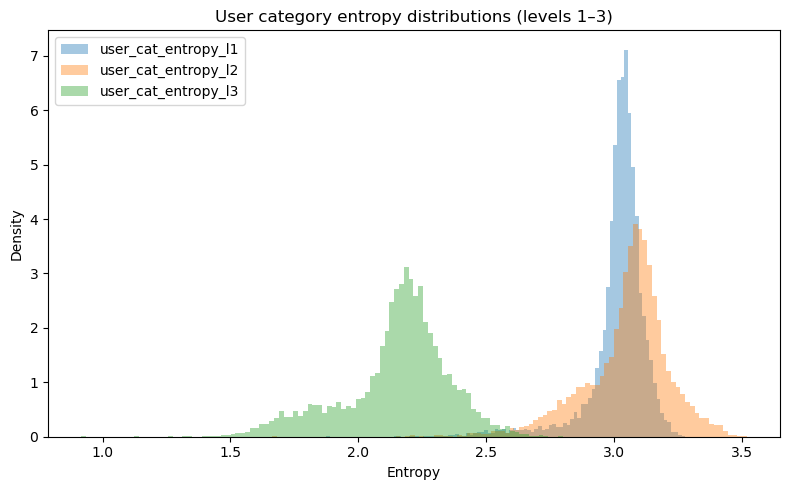

In [23]:
# Plot the entropy distributions in one figure
# Based on the distribution, level-2 entropy has higher variance and less noise so it is best for prediction

cols = [
    "user_cat_entropy_l1",
    "user_cat_entropy_l2",
    "user_cat_entropy_l3",
]

plt.figure(figsize=(8, 5))

for col in cols:
    plt.hist(
        user_cat_entropy[col].dropna(),
        bins=100,
        density=True, 
        alpha=0.4, # transparency parameter
        label=col
    )

plt.xlabel("Entropy")
plt.ylabel("Density")
plt.title("User category entropy distributions (levels 1–3)")
plt.legend()
plt.tight_layout()
plt.show()

##### (ii) Create level-2 entropy history-based feature per user

In [24]:
df = df.sort_values(["user_id", "time"]).reset_index(drop=True)

def hist_entropy_level2_per_user(group):
    """
    For each user:
        - group is a DataFrame with one column including i_cat_level2_id, sorted by time
        - return a Series of length len(group) where entry t is the entropy of the category
            history using rows [1, ..., t-1]
    """
    categories = group["i_cat_level2_id"].to_numpy()
    n = len(group)
    entry = np.empty(n, dtype="float32")

    counts = {} # dictionary for counts per category
    total = 0

    for i, c in enumerate(categories):
        if total == 0:
            entry[i] = np.nan 
        else: 
            vals = np.fromiter(counts.values(), dtype="float64")
            p = vals / vals.sum()
            entry[i] = float(-(p * np.log(p)).sum())

        counts[c] = counts.get(c, 0) + 1
        total += 1

    return pd.Series(entry, index=group.index)

df["hist_cat_entropy_l2"] = (
    df.groupby("user_id", group_keys=False)[["i_cat_level2_id"]].apply(hist_entropy_level2_per_user)
)

df["hist_cat_entropy_l2"] = df["hist_cat_entropy_l2"].fillna(0.0).astype("float32")
    

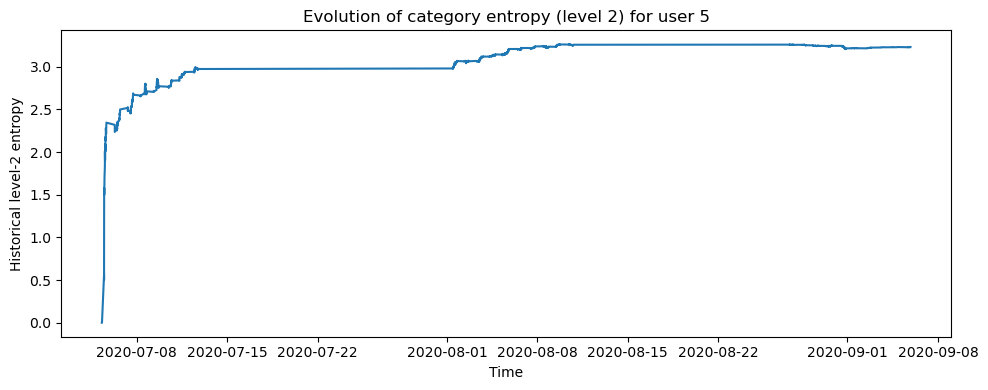

In [25]:
# Plot the entropy evolution path for a specific user

uid = 5  # or whatever user_id you want

u_hist = (
    df.loc[df["user_id"] == uid, ["time", "hist_cat_entropy_l2"]]
      .sort_values("time")        # make sure it’s in time order
)

plt.figure(figsize=(10, 4))
plt.plot(u_hist["time"], u_hist["hist_cat_entropy_l2"])
plt.xlabel("Time")
plt.ylabel("Historical level-2 entropy")
plt.title(f"Evolution of category entropy (level 2) for user {uid}")
plt.tight_layout()
plt.show()


#### (3) Author recency and the completion of last interaction with the author

##### (i) Feature creation

In [26]:
# Sort the data by user, burst, and time
df = (
    df.sort_values(["user_id", "burst_id", "time"])
      .reset_index(drop=True)
)

# Author recency within each burst
author_recency = (
    df.groupby(["user_id", "burst_id", "i_author_id"], observed=True)["time"]
      .diff()
      .dt.total_seconds()
      .div(86400.0)
)

df["hist_author_recency_days"] = author_recency.astype("float32")

# Last completion with the author within each burst
last_complete = (
    df.groupby(["user_id", "burst_id", "i_author_id"], observed=True)["y_complete"]
      .shift(1)
)

df["hist_last_complete_author"] = last_complete.astype("float32")

# Indicator: has this user seen this author before in this burst?
df["hist_has_author_history"] = author_recency.notna().astype("int8")


##### (ii) Sanity checks

In [27]:
# 1. Check missingness
df[["hist_author_recency_days",
    "hist_last_complete_author",
    "hist_has_author_history"]].describe(include="all")

,hist_author_recency_days,hist_last_complete_author,hist_has_author_history
count,3.645165e+06,3.645165e+06,1.252791e+07
mean,1.318526e+00,3.301897e-01,2.909635e-01
std,1.973446e+00,4.677764e-01,4.542067e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.894213e-01,0.000000e+00,0.000000e+00
75%,1.980546e+00,1.000000e+00,1.000000e+00
max,9.993679e+00,1.000000e+00,1.000000e+00


In [28]:
# 2. Spot-check a single (user, author) pair
u0  = df["user_id"].iloc[0]
a0  = df["i_author_id"].iloc[0]

df.loc[(df["user_id"] == u0) & (df["i_author_id"] == a0),
       ["time", "y_complete",
        "hist_author_recency_days",
        "hist_last_complete_author",
        "hist_has_author_history"]].head(20)


,time,y_complete,hist_author_recency_days,hist_last_complete_author,hist_has_author_history
0,2020-07-05 00:08:23.438,1,NaN,NaN,0
18,2020-07-06 01:14:03.743,1,1.045605,1.0,1
1489,2020-08-09 00:10:13.040,1,NaN,NaN,0


#### (4) Last session length and inter-session gap

##### (i) Feature creation

In [29]:
# 1) Sort data
df = df.sort_values(["user_id", "burst_id", "session", "time"]).reset_index(drop=True)

# 2) Session-level table within each burst
sess_level = (
    df.groupby(["user_id", "burst_id", "session"], observed=True)
      .agg(
          sess_start=("time", "min"),
          sess_end=("time", "max"),
          sess_len=("sess_len", "first"),  # constant within a session
      )
      .reset_index()
)

# 3) Previous session stats within the same burst
sess_level = sess_level.sort_values(["user_id", "burst_id", "sess_start"])

sess_level["hist_prev_sess_len"] = (
    sess_level.groupby(["user_id", "burst_id"], observed=True)["sess_len"].shift(1)
)

prev_end = sess_level.groupby(["user_id", "burst_id"], observed=True)["sess_end"].shift(1)
sess_level["hist_intersess_gap_h"] = (
    (sess_level["sess_start"] - prev_end)
      .dt.total_seconds()
      .div(3600.0)
)

# 4) Merge back to df
df = df.merge(
    sess_level[
        ["user_id", "burst_id", "session",
         "hist_prev_sess_len", "hist_intersess_gap_h"]
    ],
    on=["user_id", "burst_id", "session"],
    how="left",
)

# 5) fill NaNs for first session in each burst
df["hist_prev_sess_len"]   = df["hist_prev_sess_len"].fillna(0).astype("float32")
df["hist_intersess_gap_h"] = df["hist_intersess_gap_h"].fillna(0).astype("float32")


##### (ii) Descriptive statistics of hist_intersess_gap_hour

In [30]:
df["hist_intersess_gap_h"].describe()

count    1.252791e+07
mean     8.966358e+00
std      9.396858e+00
min      0.000000e+00
25%      1.855895e+00
50%      6.207718e+00
75%      1.470335e+01
max      2.320081e+02
Name: hist_intersess_gap_h, dtype: float64

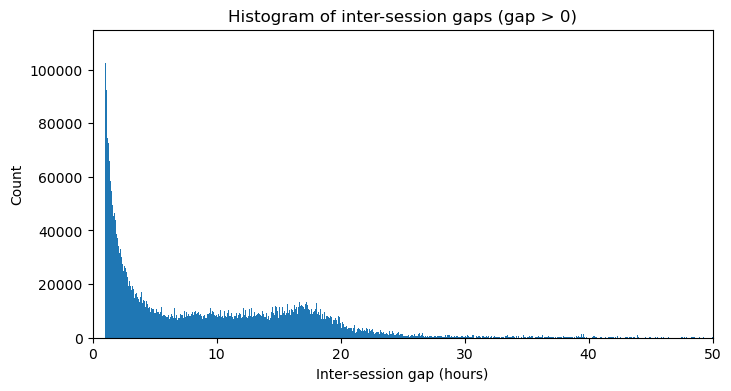

In [31]:
plt.figure(figsize=(8,4))
gap_pos = df.loc[df["hist_intersess_gap_h"] > 0, "hist_intersess_gap_h"]
plt.hist(gap_pos, bins=10000)
plt.xlim(0,50)
plt.xlabel("Inter-session gap (hours)")
plt.ylabel("Count")
plt.title("Histogram of inter-session gaps (gap > 0)")
plt.show()

In [32]:
list(df.columns)

['user_id',
 'video_id',
 'play_duration',
 'time',
 'date',
 'timestamp',
 'watch_ratio',
 'burst_id',
 'session',
 'sess_rank',
 'sess_len',
 'y_complete',
 'y_long',
 'y_rewatch',
 'y_neg',
 'u_user_active_degree',
 'u_is_lowactive_period',
 'u_is_live_streamer',
 'u_is_video_author',
 'u_follow_user_num',
 'u_follow_user_num_range',
 'u_fans_user_num',
 'u_fans_user_num_range',
 'u_friend_user_num',
 'u_friend_user_num_range',
 'u_register_days',
 'u_register_days_range',
 'u_onehot_feat0',
 'u_onehot_feat1',
 'u_onehot_feat2',
 'u_onehot_feat3',
 'u_onehot_feat4',
 'u_onehot_feat5',
 'u_onehot_feat6',
 'u_onehot_feat7',
 'u_onehot_feat8',
 'u_onehot_feat9',
 'u_onehot_feat10',
 'u_onehot_feat11',
 'u_onehot_feat12',
 'u_onehot_feat13',
 'u_onehot_feat14',
 'u_onehot_feat15',
 'u_onehot_feat16',
 'u_onehot_feat17',
 'u_follow_user_num_log1p',
 'u_fans_user_num_log1p',
 'u_friend_user_num_log1p',
 'u_register_days_log1p',
 'i_aspect_ratio',
 'i_author_id',
 'i_video_type',
 'i_uploa

### 6. Save data (both .parquet and .csv files)

In [33]:
out_path = OUT / "processed_data.parquet"

df.to_parquet(out_path, index=False)
print("Saved to:", out_path)

csv_path = OUT / "processed_data.csv"

df.to_csv(csv_path, index=False)
print("Saved CSV to:", csv_path)


Saved to: /Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/processed/processed_data.parquet
Saved CSV to: /Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/processed/processed_data.csv
